## Trigram model with Neural Nets


In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as N

%matplotlib inline

In [2]:
words = open("makemore/names.txt", "r").read().splitlines()
words[0:3]

['emma', 'olivia', 'ava']

In [3]:
chars = sorted(list(set("".join(words))))

stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {s: i for i, s in stoi.items()}

In [4]:
# create the training set of trigrams (ab, y)
xs, ys = [], []

for w in words:
    chs = ["."] + list(w) + ["."]
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):

        # ix1 = stoi[f"{ch1}{ch2}"]
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        # print(f"{ch1}{ch2}  -> {ch3}")
        xs.append((ix1 * 27) + ix2)
        ys.append(ix3)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

print(f"{xs.shape=}, {len(xs)=}, {xs.nelement()=} {xs[0:5]}")
print(f"{ys.shape=}, {len(ys)=}, {ys.nelement()=} {ys[0:5]}")
print(f"Number of examples={len(xs)=}")

xs.shape=torch.Size([196113]), len(xs)=196113, xs.nelement()=196113 tensor([  5, 148, 364, 352,  15])
ys.shape=torch.Size([196113]), len(ys)=196113, ys.nelement()=196113 tensor([13, 13,  1,  0, 12])
Number of examples=len(xs)=196113


In [5]:
g = torch.Generator().manual_seed(2147483647)
# TODO: Unsure what the shape of W should be.
W3 = torch.randn((27 * 27, 27), generator=g, requires_grad=True)

print(f"{W3.shape=}")

W3.shape=torch.Size([729, 27])


In [6]:
# Gradient descent
losses = []

for i in range(100):

    # Forward pass
    xenc = F.one_hot(xs, num_classes=27**2).float()  # One hot encoded inputs.
    logits = xenc @ W3  # log(counts)
    counts = logits.exp()  # counts, [0, +Inf]
    probs = counts / counts.sum(1, keepdim=True)  # Normalised probability with softmax.

    # Notes on sizes
    assert xenc.shape == (len(xs), 729)  # 729 dim one hot vector for each input
    assert logits.shape == (len(xs), 27)  # 27 log(count) for each input. ⁉️ Is this right?
    assert counts.shape == (len(xs), 27)  # 27 count for each input. ⁉️ Is this right?

    # For each input pair in xs, pluck label from ys to compute Negative Log Likelihood
    # NOTE: This array indexing here is impressively terse across 2 dimensions.
    nll = -probs[torch.arange(len(xs)), ys].log().mean()

    # Regularization loss
    # reg = 0.01 * W3.pow(2).mean()

    loss = nll  # + reg

    losses.append(loss.item())
    print(f"loss={loss.item()}")

    # Backward pass
    W3.grad = None
    loss.backward()

    # Update weights
    W3.data += -50 * W3.grad

loss=3.72312331199646
loss=3.647545576095581
loss=3.5766525268554688
loss=3.510436534881592
loss=3.4489150047302246
loss=3.392056703567505
loss=3.339740037918091
loss=3.291738271713257
loss=3.2477333545684814
loss=3.2073419094085693
loss=3.1701550483703613
loss=3.13577938079834
loss=3.1038622856140137
loss=3.074103593826294
loss=3.0462541580200195
loss=3.0201098918914795
loss=2.9955015182495117
loss=2.972287893295288
loss=2.9503493309020996
loss=2.929582118988037
loss=2.9098961353302
loss=2.891211986541748
loss=2.873457431793213
loss=2.85657000541687
loss=2.8404905796051025
loss=2.8251657485961914
loss=2.8105475902557373
loss=2.796590566635132
loss=2.7832517623901367
loss=2.7704930305480957
loss=2.758277177810669
loss=2.7465696334838867
loss=2.7353382110595703
loss=2.724552631378174
loss=2.7141852378845215
loss=2.7042088508605957
loss=2.6946001052856445
loss=2.685336112976074
loss=2.6763956546783447
loss=2.667760133743286
loss=2.6594111919403076
loss=2.6513326168060303
loss=2.643509387

start=3.7231, end=2.4025


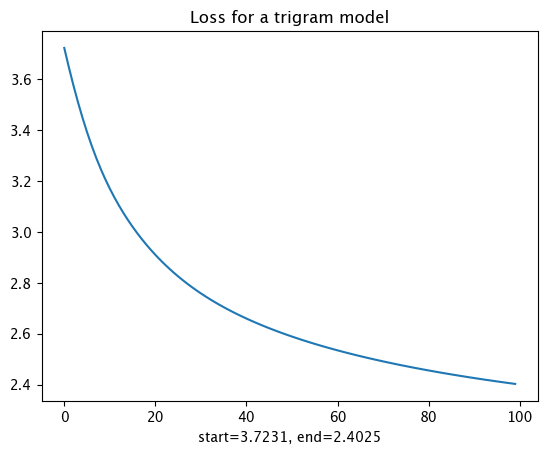

In [7]:
plt.plot(losses)
plt.title(f"Loss for a trigram model")
plt.xlabel(f"start={losses[0]:.4f}, end={losses[-1]:.4f}")

# The expected loss at the end of training should be close to the mean loss calculated earlier
print(f"start={losses[0]:.4f}, end={losses[-1]:.4f}")

**WARNING ⚠️ Notes on the probability distribution**

-   Not entirely sure if this visualization is right, but the prob distribution DEFINITELY LOOKS WRONG.
-   This looks nothing like the input dataset.
-   Some values are > 100, which is wrong.
-   Sampled output is garbage, so something went wrong before this point and I don't know what.


In [8]:
P3 = W3 / W3.sum(1, keepdim=True)  # torch.Size([196113, 2, 27])

scale = 8
plt.figure(figsize=(32 * scale, 64 * scale))
plt.imshow(P3.detach().numpy(), cmap="Blues")
plt.axis("off")

for a in range(27):
    for b in range(27):
        for c in range(27):
            chstr = itos[a] + itos[b] + itos[c]
            row = (a * 27) + b
            w = f"{P3[row , c].item():.1f}%"
            plt.text(c, row, chstr, ha="center", va="bottom", color="gray")
            plt.text(c, row, w, ha="center", va="top", color="gray")

In [ ]:
# Sample from trigram NN
# THIS IS ALMOST CERTAINLY WRONG.

g = torch.Generator().manual_seed(2147483647)

for i in range(10):

    out = []
    ix1, ix2 = 0, 0
    while True:
        xenc = F.one_hot(torch.tensor([(ix1 * 27) + ix2]), num_classes=27 * 27).float()
        # xenc = xenc.reshape((1, -1))
        logits = xenc @ W3
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdims=True)

        ix1 = ix2
        ix2 = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix2])
        if ix2 == 0:
            break
    print("".join(out))

zexzdfzjglkuriana.
otxhkmvlzimjtna.
orlkfdkzka.
oa.
zacxyhbbpwkhrigotwxezgzjeqkgxojkwptedagkkjer.
zasidey.
nkgvnrnfrftbspmhwcjdenvtahlvsuznsdrxdlngil.
pynw.
istnj.
opfdnie.
